# Skinnefy SageMaker Training Notebook
#### Assembled by:
Naman Pujari, Siddharth Rajan, Harsh Patel, Faheem Kamal

In [1]:
%%time
import boto3
import re
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri

role = get_execution_role()
print("Role = " + role)

bucket='senior-design-app-bucket' # customize to your bucket

# establishing our training image. training image is a wrapper around a preconfigured (untrained)
# ML algorithm contained inside a docker image
training_image = get_image_uri(boto3.Session().region_name, 'image-classification')

Role = arn:aws:iam::467787479766:role/service-role/AmazonSageMaker-ExecutionRole-20200305T001560
CPU times: user 871 ms, sys: 145 ms, total: 1.02 s
Wall time: 8.08 s


In [2]:
# configuring the s3 uris for input data
s3train = 's3://{}/updated_dataset/train/'.format(bucket)
s3validation = 's3://{}/updated_dataset/validation/'.format(bucket)
s3train_lst = 's3://{}/updated_dataset/train_lst/'.format(bucket)
s3validation_lst = 's3://{}/updated_dataset/validation_lst/'.format(bucket)

After setting training parameters, we kick off training, and poll for status until training is completed, which in this example, takes between 10 to 12 minutes per epoch on a p2.xlarge machine. The network typically converges after 10 epochs. However, to save the training time, we set the epochs to 2 but please keep in mind that it may not be  sufficient to generate a good model. 

In [2]:
# The algorithm supports multiple network depth (number of layers). They are 18, 34, 50, 101, 152 and 200
# we'll use 50 layers
num_layers = "101" 
# we need to specify the input image shape for the training data
image_shape = "3,244,244"
# we also need to zpecify the number of training samples in the training set
# for our dataset this is 8522 (skin dataset)
num_training_samples = "14707"
# specify the number of output classes
num_classes = "9"
# batch size for training
mini_batch_size =  "32"
# number of epochs
epochs = "100"
# learning rate
learning_rate = "0.01"

# Training
Run the training using Amazon sagemaker CreateTrainingJob API
In this part we declare important fields such as
* AlgorithmSpecification --> declaring training image to be used
* ResourceConfig --> declaring what type of compute power the training will take place on
* HyperParameters --> informing the training job of required hyperparameters

In [65]:
%%time
import time
import boto3
from time import gmtime, strftime


s3 = boto3.client('s3')
# create unique job name 
job_name_prefix = 'skinclassification-test1'
timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
job_name = job_name_prefix + timestamp
training_params = \
{
    # specify the training docker image
    "AlgorithmSpecification": {
        "TrainingImage": training_image,
        "TrainingInputMode": "File"
    },
    "RoleArn": role,
    "OutputDataConfig": {
        "S3OutputPath": 's3://{}/{}/output'.format(bucket, job_name_prefix)
    },
    "ResourceConfig": {
        "InstanceCount": 1,
        "InstanceType": "ml.p2.xlarge",
        "VolumeSizeInGB": 50
    },
    "TrainingJobName": job_name,
    "HyperParameters": {
        "image_shape": image_shape,
        "num_layers": str(num_layers),
        "num_training_samples": str(num_training_samples),
        "num_classes": str(num_classes),
        "mini_batch_size": str(mini_batch_size),
        "epochs": str(epochs),
        "learning_rate": str(learning_rate)
    },
    "StoppingCondition": {
        "MaxRuntimeInSeconds": 360000
    },
#Training data should be inside a subdirectory called "train"
#Validation data should be inside a subdirectory called "validation"
#The algorithm currently only supports fullyreplicated model (where data is copied onto each machine)
    "InputDataConfig": [
        {
            "ChannelName": "train",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3train,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3validation,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "train_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3train_lst,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
        {
            "ChannelName": "validation_lst",
            "DataSource": {
                "S3DataSource": {
                    "S3DataType": "S3Prefix",
                    "S3Uri": s3validation_lst,
                    "S3DataDistributionType": "FullyReplicated"
                }
            },
            "ContentType": "application/x-image",
            "CompressionType": "None"
        },
    ]
}
print('Training job name: {}'.format(job_name))
print('\nInput Data Location: {}'.format(training_params['InputDataConfig'][0]['DataSource']['S3DataSource']))

Training job name: skinclassification-test1-2020-03-18-02-02-53

Input Data Location: {'S3DataType': 'S3Prefix', 'S3Uri': 's3://senior-design-app-bucket/dataset/train/', 'S3DataDistributionType': 'FullyReplicated'}
CPU times: user 6.09 ms, sys: 0 ns, total: 6.09 ms
Wall time: 6.1 ms


In [ ]:
# create the Amazon SageMaker training job
sagemaker = boto3.client(service_name='sagemaker')
sagemaker.create_training_job(**training_params) # creates the training job using the arguments defined above

# confirm that the training job has started
status = sagemaker.describe_training_job(TrainingJobName=job_name)['TrainingJobStatus']
print('Training job current status: {}'.format(status))

try:
    # wait for the job to finish and report the ending status
    sagemaker.get_waiter('training_job_completed_or_stopped').wait(TrainingJobName=job_name)
    training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
    status = training_info['TrainingJobStatus']
    print("Training job ended with status: " + status)
except:
    print('Training failed to start')
     # if exception is raised, that means it has failed
    message = sagemaker.describe_training_job(TrainingJobName=job_name)['FailureReason']
    print('Training failed with the following error: {}'.format(message))

Training job current status: InProgress


In [67]:
training_info = sagemaker.describe_training_job(TrainingJobName=job_name)
status = training_info['TrainingJobStatus']
print("Training job ended with status: " + status)
print(training_params['OutputDataConfig'])

Training job ended with status: Completed
{'S3OutputPath': 's3://senior-design-app-bucket/skinclassification-test1/output'}


# Deploy The Model

A trained model does nothing on its own. We now want to use the model to perform inference. 

## Create Model

We now create a SageMaker Model from the training output. Using the model we can create Endpoint, for real time inference from our React Native app.

In [5]:
%%time
import boto3

sage = boto3.Session().client(service_name='sagemaker') 

model_name="skinnefy-training-version2-model"
print(model_name)
info = sage.describe_training_job(TrainingJobName="skinnefy-training-version2")
model_data = info['ModelArtifacts']['S3ModelArtifacts']
print(model_data)

hosting_image = get_image_uri(boto3.Session().region_name, 'image-classification')

primary_container = {
    'Image': hosting_image,
    'ModelDataUrl': model_data,
}

create_model_response = sage.create_model(
    ModelName = model_name,
    ExecutionRoleArn = role,
    PrimaryContainer = primary_container)

print(create_model_response['ModelArn'])

skinnefy-training-version2-model
s3://senior-design-app-bucket/tuning_output/skinnefy-training-version2/output/model.tar.gz
arn:aws:sagemaker:us-east-2:467787479766:model/skinnefy-training-version2-model
CPU times: user 84.4 ms, sys: 3.79 ms, total: 88.2 ms
Wall time: 559 ms


### Realtime inference

We now host the model with an endpoint and perform realtime inference.

#### Create Endpoint Configuration
The endpoint configuration describes the instance type required for model deployment, including the model that must be hosted on it. In our case, this will be the trained image-classification Convolutional Neural Network using our skin condition dataset.

In [6]:
endpoint_config_name = "skinnefy-training-version2-endpoint-config"
endpoint_config_response = sage.create_endpoint_config(
    EndpointConfigName = endpoint_config_name,
    ProductionVariants=[{
        'InstanceType':'ml.m4.xlarge',
        'InitialInstanceCount':1,
        'ModelName':model_name,
        'VariantName':'AllTraffic'}])

print('Endpoint configuration name: {}'.format(endpoint_config_name))
print('Endpoint configuration arn:  {}'.format(endpoint_config_response['EndpointConfigArn']))

Endpoint configuration name: skinnefy-training-version2-endpoint-config
Endpoint configuration arn:  arn:aws:sagemaker:us-east-2:467787479766:endpoint-config/skinnefy-training-version2-endpoint-config


#### Create Endpoint
Next, the customer creates the endpoint that serves up the model, through specifying the name and configuration defined above. The end result is an endpoint that can be called from inference from our React Native application.

In [7]:
import boto3
sagemaker = boto3.client(service_name='sagemaker')


# timestamp = time.strftime('-%Y-%m-%d-%H-%M-%S', time.gmtime())
# endpoint_name = job_name_prefix + '-ep-' + timestamp
# print('Endpoint name: {}'.format(endpoint_name))

endpoint_params = {
    'EndpointName': "skinnefy-training-version2-endpoint",
    'EndpointConfigName': "skinnefy-training-version2-endpoint-config",
}
endpoint_response = sagemaker.create_endpoint(**endpoint_params)
print('EndpointArn = {}'.format(endpoint_response['EndpointArn']))



EndpointArn = arn:aws:sagemaker:us-east-2:467787479766:endpoint/skinnefy-training-version2-endpoint


In [ ]:
# get the status of the endpoint
endpoint_name = "skinnefy-training-version2-endpoint"

response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = response['EndpointStatus']
print('EndpointStatus = {}'.format(status))


# wait until the status has changed
sagemaker.get_waiter('endpoint_in_service').wait(EndpointName=endpoint_name)


# print the status of the endpoint
endpoint_response = sagemaker.describe_endpoint(EndpointName=endpoint_name)
status = endpoint_response['EndpointStatus']
print('Endpoint creation ended with EndpointStatus = {}'.format(status))

if status != 'InService':
    raise Exception('Endpoint creation failed.')

EndpointStatus = Creating


##### Evaluating a test image 
We can use the endpoint we just hosted to see if it can produce accurate predictions.
We will provide it an image of acne and see what it predicts

download: s3://senior-design-app-bucket/dataset/test/acne_and_rosacea/acne-cystic-51.jpg to ./tmp.jpg


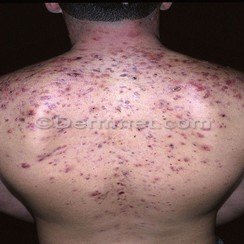

In [85]:
from IPython.display import Image

s3test = 's3://{}/dataset/test/acne_and_rosacea/'.format(bucket)
img_path = s3test + 'acne-cystic-51.jpg'

!aws s3 cp $img_path tmp.jpg
Image('./tmp.jpg')

In [86]:
import json
import numpy as np

with open('./tmp.jpg', 'rb') as f:
    payload = f.read()
    payload = bytearray(payload)
response = runtime.invoke_endpoint(EndpointName=endpoint_name, 
                                   ContentType='application/x-image', 
                                   Body=payload) # very very important
result = response['Body'].read()
# result will be in json format and convert it to ndarray
result = json.loads(result)
print(result)
# the result will output the probabilities for all classes
# find the class with maximum probability and print the class index
index = np.argmax(result)

# in the lst file we labelled classes as the following:
# 0 = acne
# 1 = melanoma
# 2 = warts
object_categories = ['acne', 'melanoma', 'warts']

print("Result: label - " + object_categories[index] + ", probability - " + str(result[index] * 100) + "%")

[0.9006906151771545, 9.600288422006997e-07, 0.09930843859910965]
Result: label - acne, probability - 90.06906151771545%
